In [54]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import seaborn as sns


In [34]:
# gb_bounce_df = pd.read_csv('../../data/derived/plays/gb_bounce_df.csv').drop(columns=['Unnamed: 0']).drop(columns=['Unnamed: 0.1'])
# all_gb_df = pd.read_csv('../../data/derived/plays/all_gb_df.csv').drop(columns=['Unnamed: 0'])
# ball_pos_df = pd.read_csv('../../data/combined/ball_pos.csv').drop('Unnamed: 0', axis=1)

# gb_bounce_df = gb_bounce_df[['game_str', 'play_id', 'at_bat', 'play_per_game', 'timestamp']]
# gb_bounce_df = gb_bounce_df.merge(all_gb_df, on=['game_str', 'play_id', 'at_bat', 'play_per_game'], how='inner',
#                                   suffixes=['_bounce_or_receieve', '_contact'])
# gb_bounce_df.drop(columns=['game_event_index', 'player_position', 'event_code'], inplace=True)

# gb_bounce_df = gb_bounce_df.merge(ball_pos_df, on=['game_str', 'play_id'], how='inner')
# gb_bounce_df.rename({'timestamp': 'ball_timestamp'}, axis=1, inplace=True)

# def create_features(group):
    

# # Print first 5 rows of gb_bounce_df grouped by game_str
# gb_prop_df = pd.DataFrame(columns=['game_str', 'play_id', 'at_bat', 'play_per_game', 'time_since_contact',
#                                    'exit_velo', 'num_bounces', 'distance'])
# grouped = gb_bounce_df.groupby(['game_str', 'play_id'])
# for name, group in grouped:
#     gb_features = create_features(group)
#     if not gb_features.empty:


In [36]:
all_gb_df = pd.read_csv('../../data/derived/plays/all_gb_df.csv').drop(columns=['Unnamed: 0'])

# Combine ground balls to first base and infield ground balls
inf_gb_df = pd.concat([
    pd.read_csv('../../data/derived/plays/inf_gb_with_throw_1b_df.csv').drop('Unnamed: 0', axis=1),
    pd.read_csv('../../data/derived/plays/first_base_gb_df.csv').drop('Unnamed: 0', axis=1)
    ])

ball_pos_df = pd.read_csv('../../data/combined/ball_pos.csv').drop('Unnamed: 0', axis=1)

# Create dataframe of ball pos on ground balls:
# Many of these rows will be empty because they aren't in inf_gb_df which has events for when ball 
# is fielded but has data about bounces on the way to the fielder
ball_pos_gb_df = pd.merge(ball_pos_df, inf_gb_df, on=['game_str', 'play_id', 'timestamp'], how='left')

# Create an empty DataFrame to store calculated ball positions data
gb_ball_pos_df = pd.DataFrame(columns=['exit_velocity', 'distance_to_home', 'time_since_contact'])
gb_ball_pos_df_2 = pd.DataFrame(columns=['exit_velocity', 'distance_to_home', 'time_since_contact', 'num_bounces'])

# Iterate through each row in the infield ground ball DataFrame
for index, row in inf_gb_df.iterrows():
    # Get the preliminary index from all_gb_df
    prelim_index = all_gb_df.loc[
        (all_gb_df['game_str'] == row['game_str']) & 
        (all_gb_df['play_id'] == row['play_id'])
    ]
    
    # Check if there are matching indices
    if prelim_index.empty:
        continue
    
    # Get the first matching index
    prelim_index = prelim_index.index[0]
    
    # Find the ball position index at the time of contact
    ball_pos_contact_index = ball_pos_gb_df.loc[
        (ball_pos_gb_df['game_str'] == row['game_str']) & 
        (ball_pos_gb_df['play_id'] == row['play_id']) & 
        (ball_pos_gb_df['timestamp'] == all_gb_df.loc[prelim_index, 'timestamp'])
    ]
    
    # Check if there's a matching ball position index
    if ball_pos_contact_index.empty:
        continue
    
    # Get the first matching ball position index
    ball_pos_contact_index = ball_pos_contact_index.index[0]
    
    # Get the indices of ball positions right after contact and the next one
    ball_pos_index_0, ball_pos_index_1 = ball_pos_contact_index + 1, ball_pos_contact_index + 2
    
    # Get the timestamps of the ball positions
    ball_pos_timestamp_0 = ball_pos_gb_df.loc[ball_pos_index_0, 'timestamp']
    ball_pos_timestamp_1 = ball_pos_gb_df.loc[ball_pos_index_1, 'timestamp']
    
    # Get the x and y positions of the ball
    x_pos_0 = ball_pos_gb_df.loc[ball_pos_index_0, 'ball_position_x']
    y_pos_0 = ball_pos_gb_df.loc[ball_pos_index_0, 'ball_position_y']
    distance_0_home = math.sqrt((x_pos_0)**2 + (y_pos_0)**2)  # Distance to home plate
    x_pos_1 = ball_pos_gb_df.loc[ball_pos_index_1, 'ball_position_x']
    y_pos_1 = ball_pos_gb_df.loc[ball_pos_index_1, 'ball_position_y']
    distance_1_home = math.sqrt((x_pos_1)**2 + (y_pos_1)**2)  # Distance to home plate
    
    # Calculate exit velocity, convert from ft/ms to mph
    exit_velo = (distance_1_home - distance_0_home) / (ball_pos_timestamp_1 - ball_pos_timestamp_0) * 1000 * 0.6818

    new_row_2 = {
        'exit_velocity': exit_velo,
        'distance_to_home': distance_1_home,
        'num_bounces': row['num_bounces'],
        'time_since_contact': row['timestamp'] - all_gb_df.loc[prelim_index, 'timestamp']
    }
    new_row_index_2 = gb_ball_pos_df_2.index.max() + 1 if not gb_ball_pos_df_2.empty else 0
    gb_ball_pos_df_2.loc[new_row_index_2] = new_row_2
    
    # Use the bounces to add data to our sample
    for i in range(1, 4):
        if not math.isnan(row[f'bounce_{i}']):
            # Find the bounce index in ball_pos_gb_df
            bounce_index = ball_pos_gb_df.loc[
                (ball_pos_gb_df['game_str'] == row['game_str']) & 
                (ball_pos_gb_df['play_id'] == row['play_id']) & 
                (ball_pos_gb_df['timestamp'] == row[f'bounce_{i}'])
            ]
            
            # Check if there's a matching bounce index
            if bounce_index.empty:
                continue
            
            # Get the first matching bounce index
            bounce_index = bounce_index.index[0]
            
            # Calculate distance from home for the bounce
            distance_bounce_home = math.sqrt(ball_pos_gb_df.loc[bounce_index, 'ball_position_x']**2 + ball_pos_gb_df.loc[bounce_index, 'ball_position_y']**2)
            time_since_contact = ball_pos_gb_df.loc[bounce_index, 'timestamp'] - all_gb_df.loc[prelim_index, 'timestamp']
            
            # Create a new row with calculated data
            new_row = {
                'exit_velocity': exit_velo,
                'distance_to_home': distance_bounce_home,
                'time_since_contact': time_since_contact
            }

            new_row_index = gb_ball_pos_df.index.max() + 1 if not gb_ball_pos_df.empty else 0
            gb_ball_pos_df.loc[new_row_index] = new_row

gb_ball_pos_df_2.head()

,exit_velocity,distance_to_home,time_since_contact,num_bounces
0,82.854374,9.107066,1881,3
1,81.458119,13.201874,1089,2
2,54.064916,9.407969,1848,2
3,85.263954,9.560252,1848,2
4,39.855908,8.826081,2178,3


       exit_velocity  distance_to_home  time_since_contact
count    2321.000000       2321.000000         2321.000000
mean       64.482991         64.223837          819.823783
std        28.881633         42.747300          653.865590
min       -36.920291          2.092794            0.000000
25%        45.111407         14.938589          100.000000
50%        67.473708         73.016025          850.000000
75%        85.838075         99.230533         1300.000000
max       174.637254        196.253623         5250.000000
       exit_velocity  distance_to_home  time_since_contact
count    1572.000000       1572.000000         1572.000000
mean       68.247979         85.911776         1101.003817
std        24.707444         28.392165          484.631195
min         0.087694         20.033953          100.000000
25%        50.471058         68.091868          750.000000
50%        72.437065         87.575840         1100.000000
75%        88.232855        106.885500         1450.0000

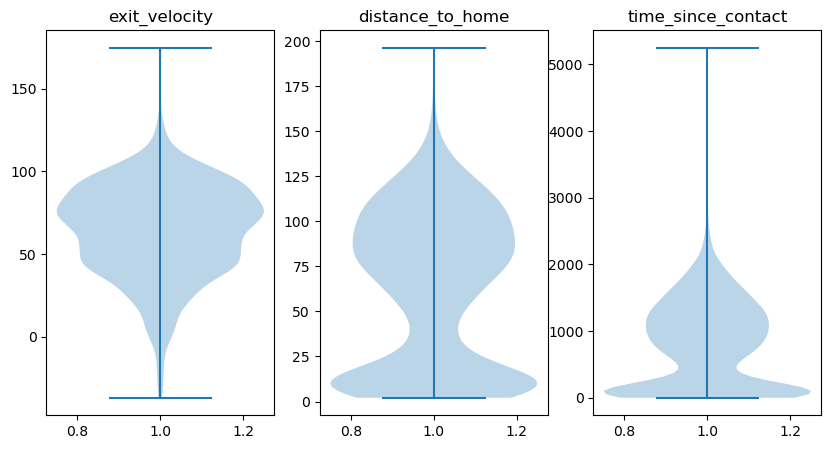

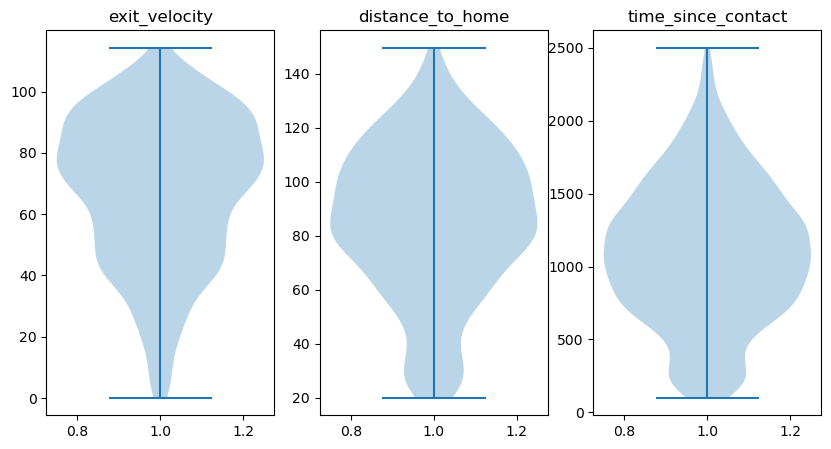

In [37]:
def feature_violin_plot(gb_ball_pos_df):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.violinplot(gb_ball_pos_df['exit_velocity'])
    plt.title('exit_velocity')

    plt.subplot(1, 3, 2)
    plt.violinplot(gb_ball_pos_df['distance_to_home'])
    plt.title('distance_to_home')

    plt.subplot(1, 3, 3)
    plt.violinplot(gb_ball_pos_df['time_since_contact'])
    plt.title('time_since_contact')

def feature_box_plot(gb_ball_pos_df):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.boxplot(gb_ball_pos_df['exit_velocity'])
    plt.title('exit_velocity')

    plt.subplot(1, 3, 2)
    plt.boxplot(gb_ball_pos_df['distance_to_home'])
    plt.title('distance_to_home')

    plt.subplot(1, 3, 3)
    plt.boxplot(gb_ball_pos_df['time_since_contact'])
    plt.title('time_since_contact')

# feature_box_plot(gb_ball_pos_df)
feature_violin_plot(gb_ball_pos_df)
print(gb_ball_pos_df.describe())

# Remove any points who exit velocity < 0 and exit velocity > 115
gb_ball_pos_df = gb_ball_pos_df[(gb_ball_pos_df['exit_velocity'] > 0) & (gb_ball_pos_df['exit_velocity'] < 115)]

# # Remove points that bounced at a distance > 180
gb_ball_pos_df = gb_ball_pos_df[gb_ball_pos_df['distance_to_home'] < 150]
# # Remove points that bounced at a distance < 10
gb_ball_pos_df = gb_ball_pos_df[gb_ball_pos_df['distance_to_home'] > 20]

# Remove points that are outside 1.5 IQR
q1 = gb_ball_pos_df.quantile(0.25)
q3 = gb_ball_pos_df.quantile(0.75)
iqr = q3 - q1
gb_ball_pos_df = gb_ball_pos_df[~((gb_ball_pos_df < (q1 - 1.5 * iqr)) |(gb_ball_pos_df > (q3 + 1.5 * iqr))).any(axis=1)]

# feature_box_plot(gb_ball_pos_df)
feature_violin_plot(gb_ball_pos_df)
print(gb_ball_pos_df.describe())

# print the 81st percentile exit velocity
print(gb_ball_pos_df['exit_velocity'].quantile(0.81))

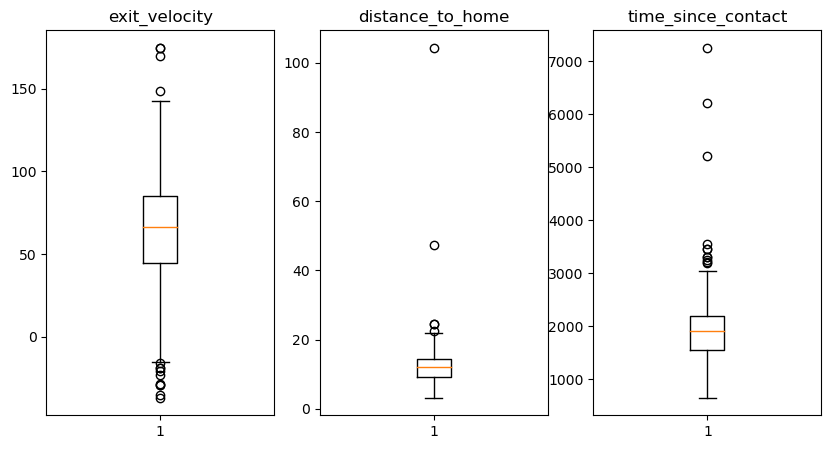

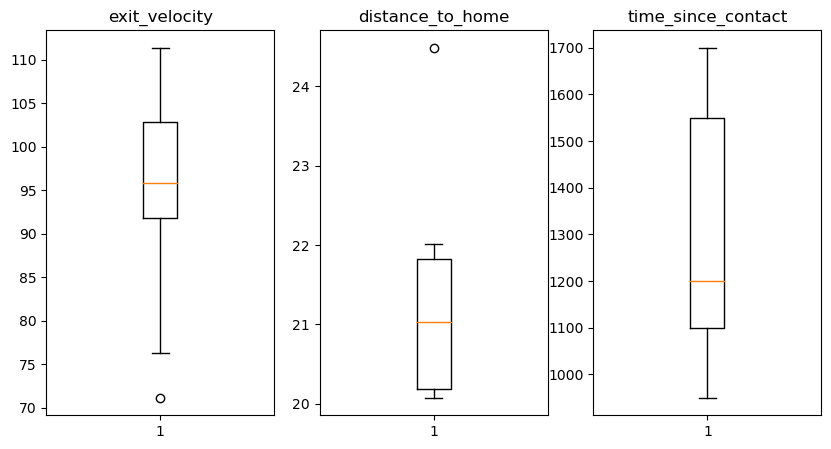

In [38]:
# Boxplot of gb_ball_pos_df_2, eliminte outlires with 1.5IQR, another boxplot.
feature_box_plot(gb_ball_pos_df_2)

# Remove any points who exit velocity < 0 and exit velocity > 115
gb_ball_pos_df_2 = gb_ball_pos_df_2[(gb_ball_pos_df_2['exit_velocity'] > 0) & (gb_ball_pos_df_2['exit_velocity'] < 115)]

# # Remove points that bounced at a distance > 180
gb_ball_pos_df_2 = gb_ball_pos_df_2[gb_ball_pos_df_2['distance_to_home'] < 150]
# # Remove points that bounced at a distance < 10
gb_ball_pos_df_2 = gb_ball_pos_df_2[gb_ball_pos_df_2['distance_to_home'] > 20]

# Remove points that are outside 1.5 IQR
q1 = gb_ball_pos_df_2.quantile(0.25)
q3 = gb_ball_pos_df_2.quantile(0.75)

iqr = q3 - q1
gb_ball_pos_df_2 = gb_ball_pos_df_2[~((gb_ball_pos_df_2 < (q1 - 1.5 * iqr)) |(gb_ball_pos_df_2 > (q3 + 1.5 * iqr))).any(axis=1)]

feature_box_plot(gb_ball_pos_df_2)

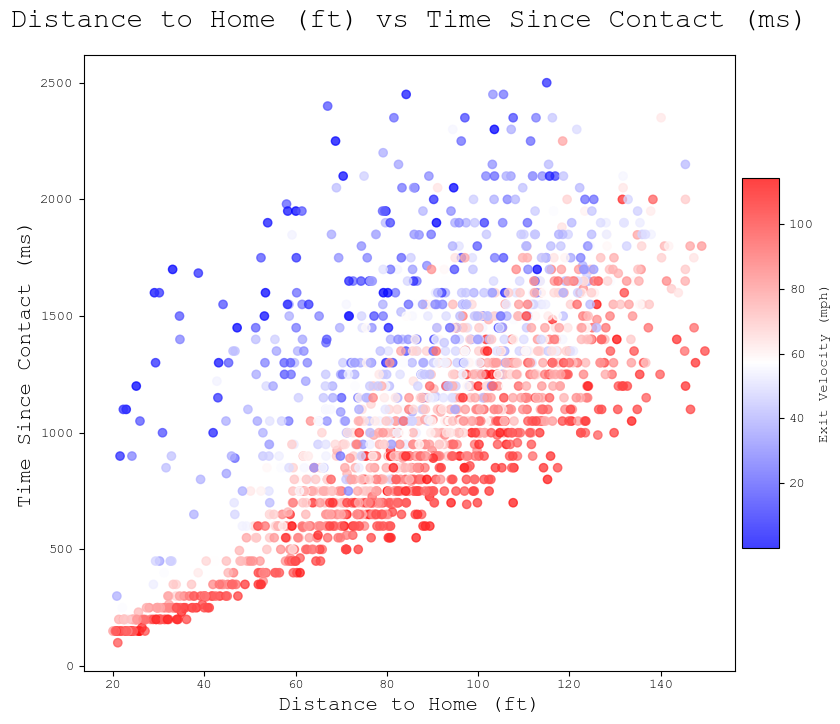

In [44]:
font = {
    'family': 'courier new',
    'size': 10
}

title_font = {
    'family': 'courier new',
    'size': 20,
}

label_font = {
    'family': 'courier new',
    'size': 15,
}

plt.rc('font', **font)

plt.figure(figsize=(10, 8))
plt.scatter(x=gb_ball_pos_df['distance_to_home'], y=gb_ball_pos_df['time_since_contact'], c=gb_ball_pos_df['exit_velocity'], cmap='bwr', alpha=0.75)
plt.colorbar(label='Exit Velocity (mph)', pad=0.01, shrink=0.6, aspect=10, fraction=0.15)
plt.xlabel('Distance to Home (ft)', **label_font)
plt.ylabel('Time Since Contact (ms)', **label_font)
plt.title('Distance to Home (ft) vs Time Since Contact (ms)', **title_font, pad=20)
plt.show()

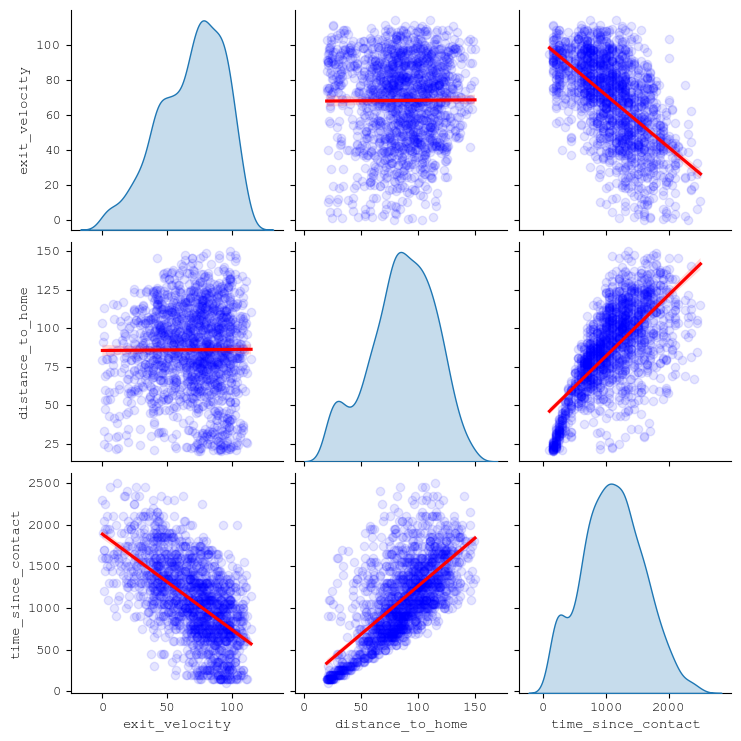

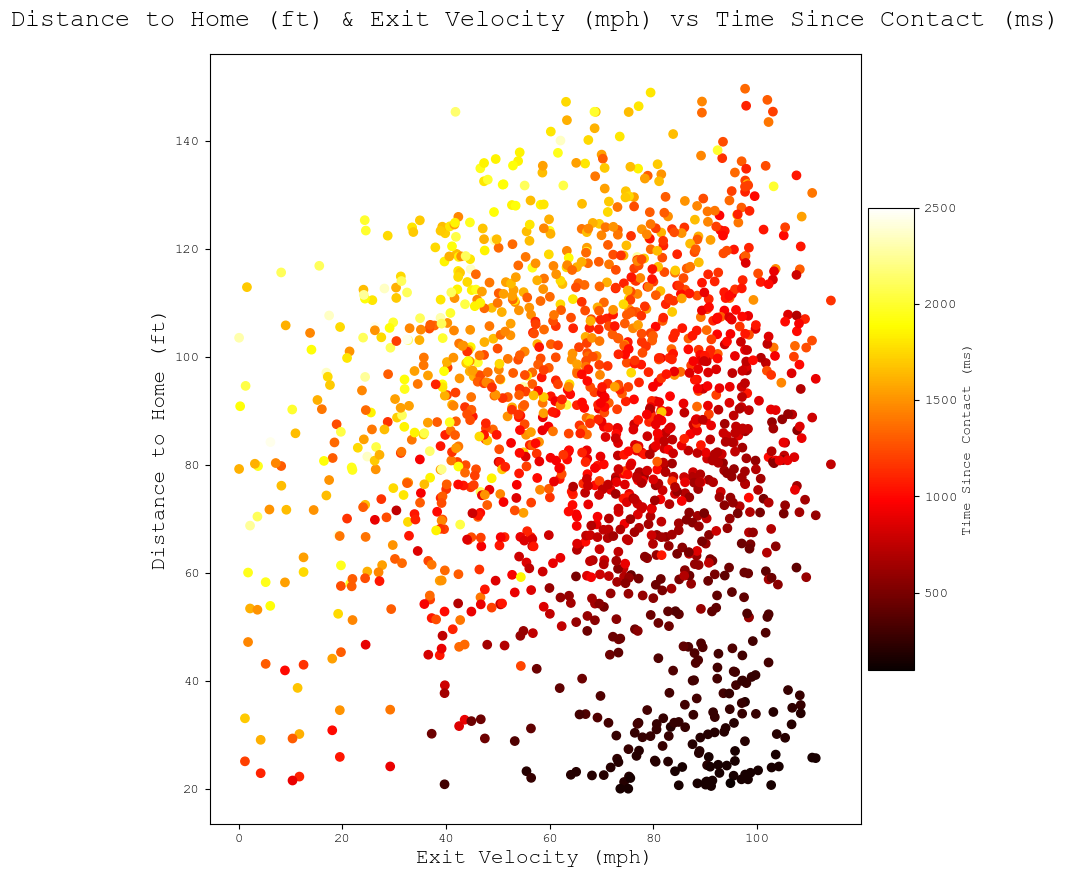

In [50]:
# sns.pairplot(throw_time_df, vars=['total_throw_distance', 'total_throw_duration', 'throw_velo_mph'], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1, 'color': 'blue'}})

sns.pairplot(gb_ball_pos_df, vars=['exit_velocity', 'distance_to_home', 'time_since_contact'], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1, 'color': 'blue'}})

plt.figure(figsize=(10, 10))
plt.scatter(x=gb_ball_pos_df['exit_velocity'], y=gb_ball_pos_df['distance_to_home'], c=gb_ball_pos_df['time_since_contact'], cmap='hot')
plt.colorbar(label='Time Since Contact (ms)', pad=0.01, shrink=0.6, aspect=10, fraction=0.15)
plt.xlabel('Exit Velocity (mph)', **label_font)
plt.ylabel('Distance to Home (ft)', **label_font)
plt.title('Distance to Home (ft) & Exit Velocity (mph) vs Time Since Contact (ms)', **title_font, pad=20)
plt.show()

y = 892.94 + 11.63 * DistanceToHome + -11.61 * Exit Velocity


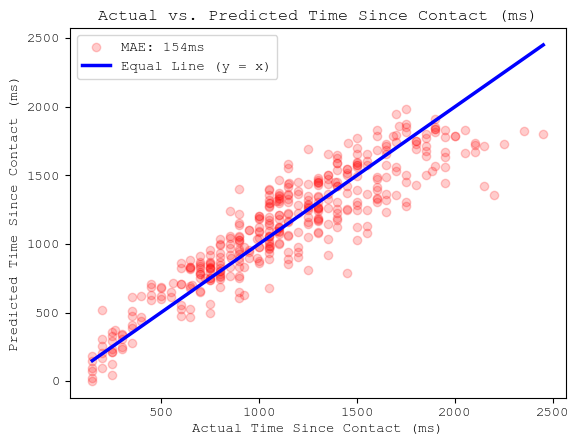

In [56]:


X = gb_ball_pos_df[['distance_to_home', 'exit_velocity']]

y = gb_ball_pos_df['time_since_contact']

# 75/25 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2001)
ball_pos_lin_model = LinearRegression()
ball_pos_lin_model.fit(X_train, y_train)

y_pred = ball_pos_lin_model.predict(X_test)

font = {'family': 'courier new'}
plt.rc('font', **font)
mae = mean_absolute_error(y_test, y_pred)
label_font = {'size':'15', 'color':'black'}
title_font = {'size':'18', 'color':'black'}

# print the equation of the regression line
print('y = {:.2f} + {:.2f} * DistanceToHome + {:.2f} * Exit Velocity'.format(ball_pos_lin_model.intercept_, ball_pos_lin_model.coef_[0], ball_pos_lin_model.coef_[1]))

# Plot actual vs. predicted with a different color palette
plt.scatter(y_test, y_pred, color='r', alpha=0.2, label='MAE: {:.0f}ms'.format(mae))
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', label='Equal Line (y = x)', lw=2.5)
plt.xlabel('Actual Time Since Contact (ms)')
plt.ylabel('Predicted Time Since Contact (ms)')
plt.title('Actual vs. Predicted Time Since Contact (ms)')
plt.legend()
plt.show()

In [49]:
# from sklearn.discriminant_analysis import StandardScaler
# from sklearn.model_selection import GridSearchCV
# from sklearn.neighbors import KNeighborsRegressor

# scaler = StandardScaler()

# X_scaled = scaler.fit_transform(X)
# X_scaled_train, X_scaled_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=2002)

# grid_space = {
#     'n_neighbors': np.arange(1, 20),
#     'weights': ['distance', 'uniform'],
# }

# grid_search = GridSearchCV(
#     KNeighborsRegressor(),
#     grid_space,
#     cv=5,
#     scoring='neg_mean_squared_error',
# )


# grid_search.fit(X_scaled_train, y_train)
# best_params = grid_search.best_params_
# best_params

# # Print message that this means that optimal hyper parameters are k = n_neighbors and if weights='distance' we use weighted average
# # of the k nearest neighbors, otherwise we use uniform average of the k nearest neighbors.
# print(f'Optimal hyper parameters:\n\tk = {best_params["n_neighbors"]}\n\taverage = {best_params["weights"]}')

# knn_model = KNeighborsRegressor(n_neighbors=best_params['n_neighbors'], weights='distance')
# knn_model.fit(X_scaled_train, y_train)

# y_pred_knn = knn_model.predict(X_scaled_test)

# knn_rmse = mean_squared_error(y_test, y_pred_knn, squared=False)
# print('knn_rmse:', knn_rmse)